# DC motor - physics-informed neural network


## Přehled

Difrenciální rovnice
$$
\dfrac{d \omega(t)}{d t} = \dfrac{1}{J}(K_{\tau}i(t) - b\omega(t))~, \\
\dfrac{d i(t)}{d t} = \dfrac{1}{L}(V - Ri(t) - K_{\tau}\omega(t))~
$$
Počáteční podmínky
$$
q(0) = 0,~~ i(t) = 0, ~~\theta(0) = 0,~~ \omega = 0,
$$



Potřebné knihovny:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [12]:
from PIL import Image
from scipy.integrate import solve_ivp

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math



## Numerické řešení

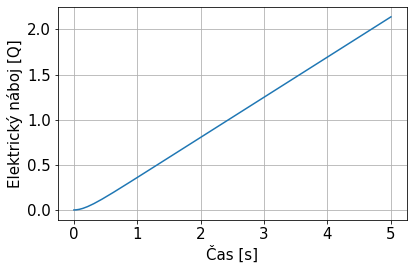

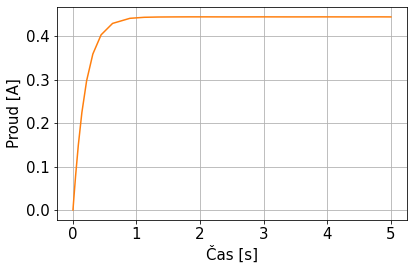

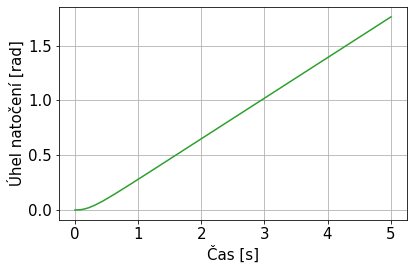

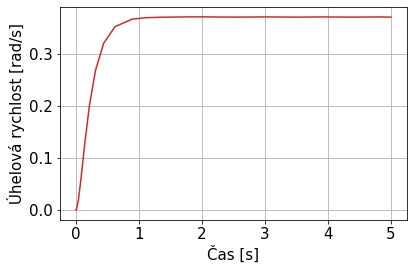

In [13]:
    
def f(t, x):
    q = x[0];
    i = x[1];
    theta = x[2];
    omega = x[3];

    L = 0.5;  # motor inductance [H]
    Rw = 1.0;  # motor winding resistance [Ohm]
    ktau = 1.5;  # motor torque constant [N*m/A]
    b = 1.8;  # Rotor viscous friction [N*m*s]
    J = 0.1;  # Rotor inertia [kg*m^2]

    # L = 0.2;  # motor inductance [H]
    # Rw = 0.5;  # motor winding resistance [Ohm]
    # ktau = 0.6;  # motor torque constant [N*m/A]
    # b = 0.05;  # Rotor viscous friction [N*m*s]
    # J = 0.3;  # Rotor inertia [kg*m^2]

    xdot = [0 ,0 ,0, 0]

    # if t < 1:
    #     V = 0
    # else:
    #     V = 0.5
    #V = math.sin(t)
    V = 1

    xdot[0] = i
    xdot[1] = (-Rw*i - ktau*omega + V) / L
    xdot[2] = omega
    xdot[3] = (-b*omega + ktau*i) / J

    return xdot

x0 = [0, 0, 0, 0]
t = np.linspace(0, 5000, 1000)

x = solve_ivp(f, t, x0)
plt.figure()
p1, = plt.plot(x.t,x.y[0],color="tab:blue")
plt.xlabel('Čas [s]', size=15)
plt.ylabel('Elektrický náboj [Q]',size=15)
plt.grid()
plt.tight_layout()
plt.savefig('imgs/charge.pdf')

plt.figure()
p2, = plt.plot(x.t,x.y[1],color="tab:orange")
plt.xlabel('Čas [s]', size=15)
plt.ylabel('Proud [A]', size=15)
plt.grid()
plt.tight_layout()
plt.savefig('imgs/current.pdf',bbox_inches="tight")

plt.figure()
p3, = plt.plot(x.t,x.y[2],color="tab:green")
plt.xlabel('Čas [s]', size=15)
plt.grid()
plt.ylabel('Úhel natočení [rad]', size=15)
plt.tight_layout()


plt.figure()
p4, = plt.plot(x.t,x.y[3],color="tab:red")
plt.xlabel('Čas [s]', size=15)
plt.grid()
plt.ylabel('Úhelová rychlost [rad/s]', size=15)
plt.tight_layout()

#plt.legend([p1,p2,p3,p4], ['Charge Q [C]','Current I [A]', 'Angle theta [rad]','Angular velocity omega [rad/s]'])
#plt.xlabel('time [t]')
#plt.show()    
plt.savefig('imgs/num.pdf')



## Architektura

In [14]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x_out = self.fce(x)

        return x_out

## Generování dat


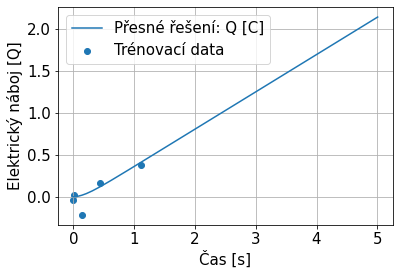

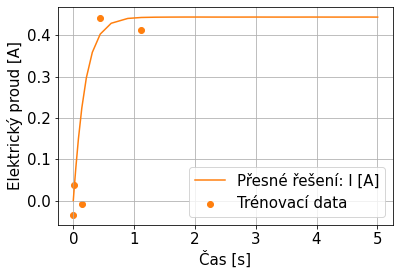

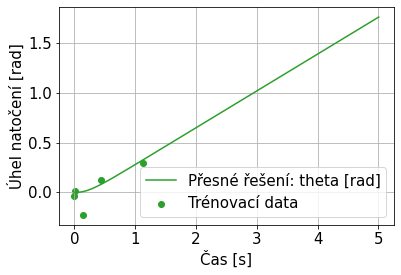

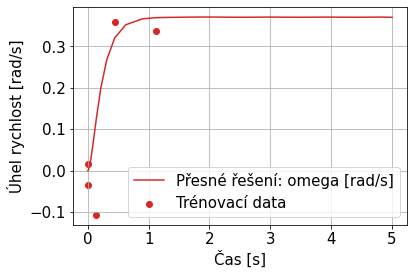

In [15]:

# get the analytical solution over the full domain
x_new = x.t
x_new = x_new.reshape((x_new.shape[0],1))
x_new = x_new.astype(np.float32)
x_new = torch.from_numpy(x_new)

noise = np.random.normal(0,2000,30)
y1 = x.y[0] + noise*0.00005
y2 = x.y[1] + noise*0.00005
y3 = x.y[2] + noise*0.00005
y4 = x.y[3] + noise*0.00005


# x_data = x.t[0:7:2]
# y_data1 = y1[0:7:2]
# y_data2 = y2[0:7:2]
# y_data3 = y3[0:7:2]
# y_data4 = y4[0:7:2]

x_data = x.t[0:15:3]
y_data1 = y1[0:15:3]
y_data2 = y2[0:15:3]
y_data3 = y3[0:15:3]
y_data4 = y4[0:15:3]

x_data = x_data.reshape((x_data.shape[0],1))
x_data = x_data.astype(np.float32)
x_data = torch.from_numpy(x_data)

y_data1 = y_data1.reshape((y_data1.shape[0],1))
y_data1 = y_data1.astype(np.float32)
y_data1 = torch.from_numpy(y_data1)

y_data2 = y_data2.reshape((y_data2.shape[0],1))
y_data2 = y_data2.astype(np.float32)
y_data2 = torch.from_numpy(y_data2)

y_data3 = y_data3.reshape((y_data3.shape[0],1))
y_data3 = y_data3.astype(np.float32)
y_data3 = torch.from_numpy(y_data3)

y_data4 = y_data4.reshape((y_data4.shape[0],1))
y_data4 = y_data4.astype(np.float32)
y_data4 = torch.from_numpy(y_data4)

plt.rcParams['font.size'] = 15
plt.figure()
plt.plot(x.t, x.y[0],color="tab:blue", label="Přesné řešení: Q [C]")
plt.scatter(x_data, y_data1, color="tab:blue", label="Trénovací data")
plt.xlabel('Čas [s]',size=15)
plt.ylabel('Elektrický náboj [Q]',size=15)
plt.grid()
plt.legend()

plt.figure()
plt.plot(x.t, x.y[1],color="tab:orange", label="Přesné řešení: I [A]")
plt.scatter(x_data, y_data2, color="tab:orange", label="Trénovací data")
plt.xlabel('Čas [s]',size=15)
plt.ylabel('Elektrický proud [A]',size=15)
plt.grid()
plt.legend()
plt.savefig('imgs/current_dots.pdf',bbox_inches="tight")

plt.figure()
plt.plot(x.t, x.y[2], color="tab:green", label="Přesné řešení: theta [rad]")
plt.scatter(x_data, y_data3, color="tab:green", label="Trénovací data")
plt.xlabel('Čas [s]',size=15)
plt.ylabel('Úhel natočení [rad]',size=15)
plt.legend()
plt.grid()

plt.figure()
plt.plot(x.t, x.y[3], color="tab:red", label="Přesné řešení: omega [rad/s]")
plt.scatter(x_data, y_data4, color="tab:red", label="Trénovací data")
plt.xlabel('Čas [s]',size=15)
plt.ylabel('Úhel rychlost [rad/s]',size=15)
plt.legend()
plt.grid()   
#plt.savefig('imgs/points.pdf')

## Generátor grafů

In [16]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.rcParams['font.size'] = 15
    plt.figure(figsize=(8,4))
    plt.plot(x,y, 'k--', linewidth=2, alpha=0.8, label="Přesné řešení")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Predikce neuronové sítě")
    plt.scatter(x_data, y_data, s=60, color="tab:red", label='Trénovací data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Pozice fyzikální ztráty')
    l = plt.legend( fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlabel('Čas [s]', size=18)
    plt.ylabel('Elektrický proud [A]', size=18)
    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-1.1, 1.1)
    plt.text(0.5,0.5,"Trénovací krok: %i"%(i+1),fontsize="xx-large",color="k")
    #plt.axis("off")
    plt.grid() 

## Klasická neuronová síť (NN)

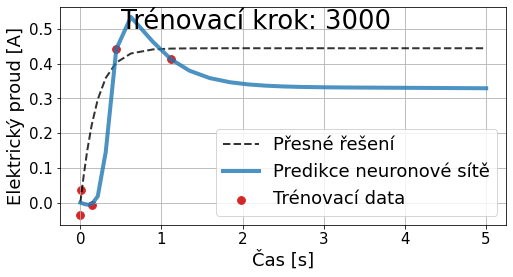

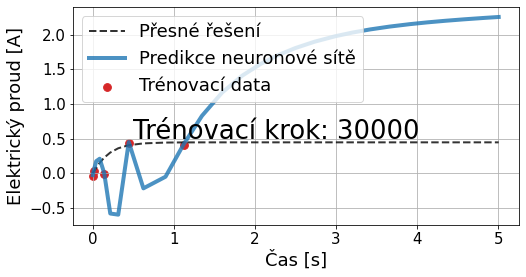

In [17]:

    
    
# train standard neural network to fit training data
torch.manual_seed(123)
model1 = FCN(1,1,12,3)
model2 = FCN(1,1,12,3)
optimizer1 = torch.optim.Adam(model1.parameters(),lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(),lr=1e-3)
files = []
for i in range(30000):
    optimizer1.zero_grad()
    yh1 = model1(x_data)
    loss1 = torch.mean((yh1-y_data2)**2)# use mean squared error
    loss1.backward()
    optimizer1.step()
    
    # plot the result as training progresses
    if (i+1) % 100 == 0: 
        
        yh1 = model1(x_new).detach()
        yh2 = model2(x_new).detach()
        
        plot_result(x.t,x.y[1],x_data,y_data2,yh1)


        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
            
        if (i+1) == 3000 or (i+1) == 30000 :
            plt.savefig(f'imgs/nn_noisy{i}.pdf',bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            plt.show()
        else: plt.close("all")
            
#save_gif_PIL("nn.gif", files, fps=20, loop=0)

## Physics informed neural network (PINN)

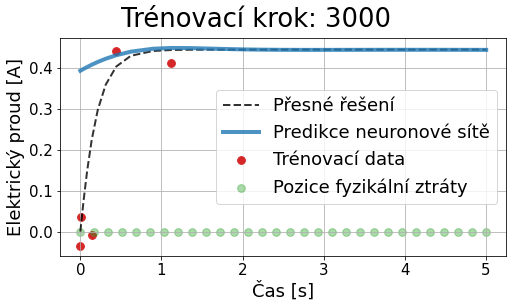

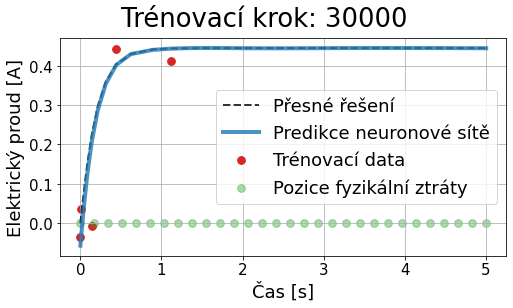

In [18]:
x_physics = torch.linspace(0,5,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
# Declare the constants. Make sure units are compatible!
L = 0.5;  # motor inductance [H]
Rw = 1.0;  # motor winding resistance [Ohm]
ktau = 1.5;  # motor torque constant [N*m/A]
b = 1.8;  # Rotor viscous friction [N*m*s]
J = 0.1;  # Rotor inertia [kg*m^2]

U = 1

# L = 10.1;  # motor inductance [H]
# Rw = 0.1;  # motor winding resistance [Ohm]
# ktau = 1.5;  # motor torque constant [N*m/A]
# b = 0.1;  # Rotor viscous friction [N*m*s]
# J = 10;  # Rotor inertia [kg*m^2]
# U =1 

# L = 0.2;  # motor inductance [H]
# Rw = 0.5;  # motor winding resistance [Ohm]
# ktau = 0.6;  # motor torque constant [N*m/A]
# b = 0.05;  # Rotor viscous friction [N*m*s]
# J = 0.3;  # Rotor inertia [kg*m^2]

# L = 7.0;  # motor inductance [H]
# Rw = 0.5;  # motor winding resistance [Ohm]
# ktau = 5.5;  # motor torque constant [N*m/A]
# b = 0.3;  # Rotor viscous friction [N*m*s]
# J = 0.3;  # Rotor inertia [kg*m^2]

torch.manual_seed(123)
model1 = FCN(1,1,32,3)
model2 = FCN(1,1,32,3)
optimizer1 = torch.optim.Adam(model1.parameters(),lr=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(),lr=1e-4)
files = []
for i in range(30000):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    
    # compute the "data loss" for the Current
    yh_I = model1(x_data)
    loss1 = torch.mean((yh_I-y_data2)**2)# use mean squared error 

    yh_AV = model2(x_data)
    loss2 = torch.mean((yh_AV-y_data4)**2)# use mean squared error   

    # compute the "physics loss" for the Current
    yhp_I = model1(x_physics)
    dx_I  = torch.autograd.grad(yhp_I, x_physics, torch.ones_like(yhp_I), create_graph=True)[0]# computes dy/dx

    # compute the "physics loss" for the angular velocity
    yhp_AV = model2(x_physics)
    dx_AV  = torch.autograd.grad(yhp_AV, x_physics, torch.ones_like(yhp_AV), create_graph=True)[0]# computes dy/dx


    physics1 = (ktau*yhp_I - b*yhp_AV)/J - dx_AV
    physics2 = (U - Rw*yhp_I - ktau*yhp_AV)/L - dx_I

    loss3 = (1e-2)*torch.mean(physics1**2)
    loss4 = (1e-2)*torch.mean(physics2**2)
    
    # backpropagate joint loss
    loss_sum_1 =0.001*loss1 + loss3 + loss4# add two loss terms together
    loss_sum_1.backward()
    optimizer1.step()

    optimizer2.step()

    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh1 = model1(x_new).detach()
        yh2 = model2(x_new).detach()
        xp = x_physics.detach()
        
        plot_result(x.t,x.y[1],x_data,y_data2,yh1, xp)
        #plot_result(x.t,x.y[3],x_data,y_data4,yh2, xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) == 3000 or (i+1) == 30000: 
            plt.savefig(f'imgs/pinn_noisy{i}.pdf',bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            plt.show()
        else: plt.close("all")
            